In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
import polars as pl
import pandas as pd
import plotly.graph_objects as go
import utm
import h3

repo_root = Path(os.getcwd()).parent

while not (repo_root / ".git").exists():
    repo_root = repo_root.parent

sys.path.append(str(repo_root))

# set the pandas plotting backend to plotly
pd.options.plotting.backend = "plotly"

## Load Radar Data


In [4]:
## Read in the Data
from src.filtering import Filtering
from src.lane_detection import LaneDetection


df = pl.scan_parquet(
    "/Users/max/Library/CloudStorage/Box-Box/Radar-Data/new_format/1678*.parquet",
    rechunk=True,
)

# create the file paths
network_outline_file = repo_root / "geo_data" / "network_outline.geojson"
radar_locations_file = repo_root / "geo_data" / "radar_origins.json"

In [5]:
f = Filtering(
    radar_location_path=radar_locations_file,
    network_boundary_path=network_outline_file,
)

interest_df = (
    df
    .filter(pl.col("epoch_time").dt.day() == 14)
    .pipe(f.create_object_id)
    .pipe(f.object_id_2_int)
    .pipe(f.crop_radius, radius=220)
    .pipe(f.crop_angle)
    # have to collect here because the next step involves am expensive operation
    .collect(streaming=True)
    .pipe(f.filter_short_trajectories, minimum_distance_m=50, minimum_duration_s=5)
)

function: object_id_2_int took: 0.00010395050048828125 seconds
function: crop_radius took: 0.000576019287109375 seconds
function: crop_angle took: 0.0018029212951660156 seconds


ArrowErrorException: ExternalFormat("File out of specification: underlying IO error: Operation timed out (os error 60)")

In [ ]:
## Print the extent of data time
print(
    (
        (interest_df["epoch_time"].max() - interest_df["epoch_time"].min()).seconds
        / 60
        / 60
    ),
    "hours",
)

print(
    interest_df.shape[0] / 1e6,
)

23.99972222222222 hours
26.113582


In [ ]:
interest_df['ip'].unique()

ip
str
"""10.160.7.141"""
"""10.160.7.137"""
"""10.160.7.142"""
"""10.160.7.136"""
"""10.160.7.147"""
"""10.160.7.146"""


## Create the Lane Detection Object

In [ ]:
ld = LaneDetection(
    df=interest_df.filter(pl.col("ip") == "10.160.7.146"),
)

In [ ]:
ld = ld.bin_data()

function: bin_data took: 1.1234312057495117 seconds


function: percentile_filter took: 0.10832619667053223 seconds


(<Figure size 640x480 with 1 Axes>, <Axes: >)

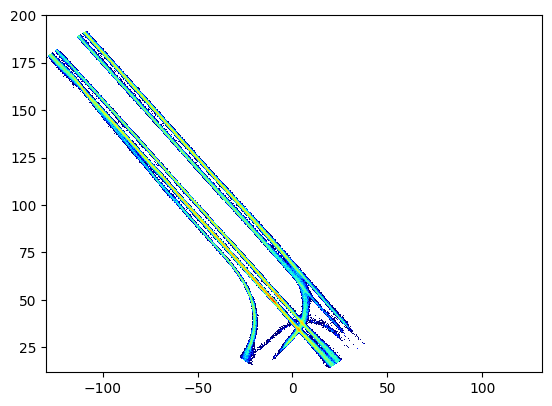

In [ ]:
ld = ld.percentile_filter(40)

ld.plot_histogram("p_hist")

function: gaussian_filter took: 0.049282073974609375 seconds


(<Figure size 640x480 with 1 Axes>, <Axes: >)

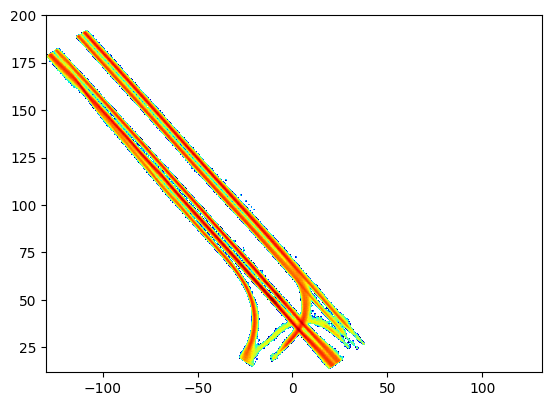

In [ ]:
ld = ld.gaussian_filter(sigma=2)

ld.plot_histogram("p_hist_smooth")

function: find_peaks took: 0.1293790340423584 seconds


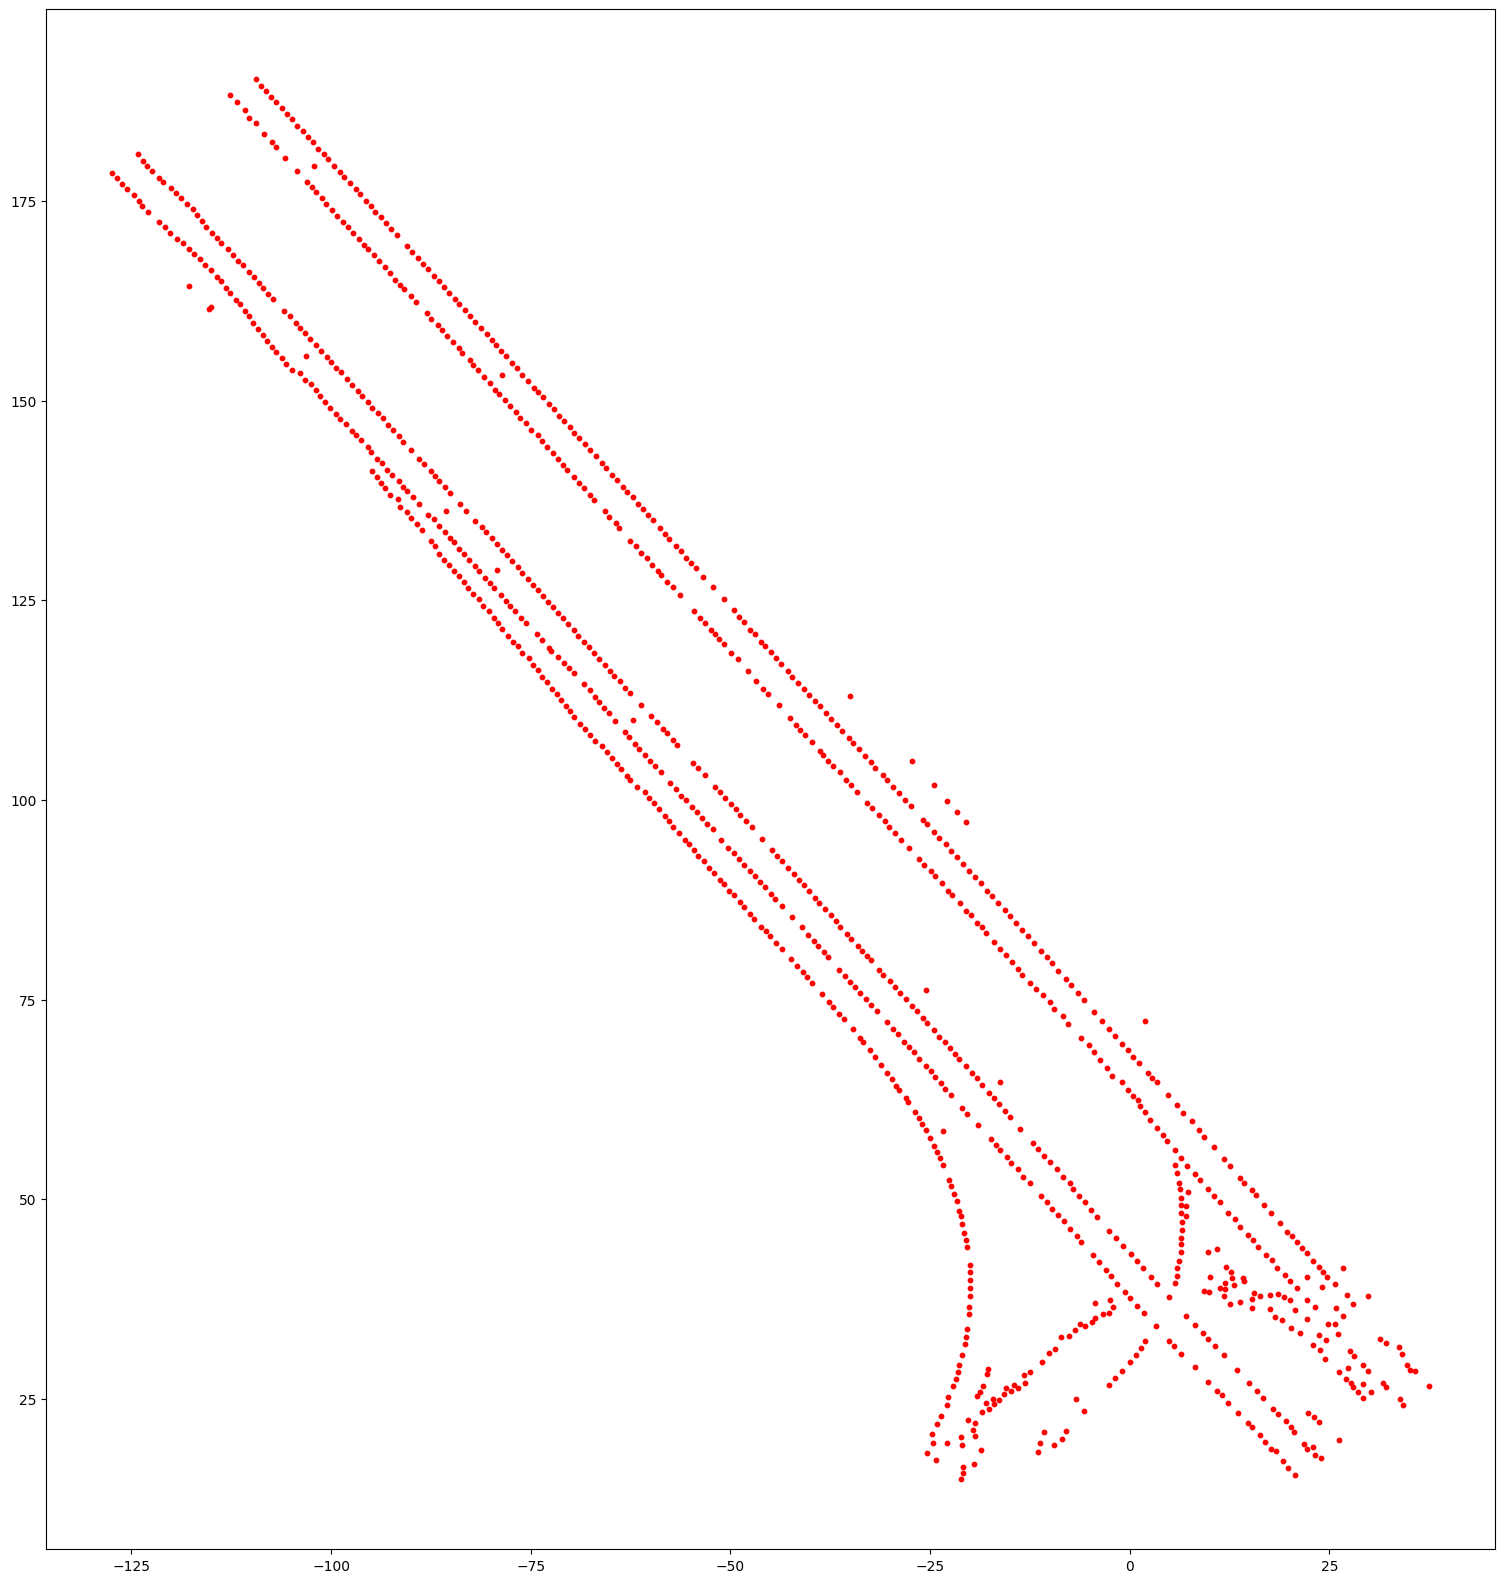

In [ ]:
ld = ld.find_peaks(min_distance=3, threshold_quantile=0.9)

fig, ax = ld.plot_peaks()

# update the size of the figure
fig.set_size_inches(20, 20)

## Snap the Radar Data to the Grid

In [ ]:
ld = (
    ld
    .snap_df_to_grid()
    .create_transition_df(
        valid_radius_m=10,
        filter_count_quantile=60,
    )
)

function: snap_df_to_grid took: 6.763200044631958 seconds
function: create_transition_df took: 1.5288429260253906 seconds


## Make the Graph

function: _update_weights took: 0.0029549598693847656 seconds
function: _add_distance took: 0.011236906051635742 seconds
function: drop_bidirectional_edges took: 0.0007731914520263672 seconds
function: _make_angle_cache took: 0.0234377384185791 seconds
function: make_graph took: 0.0441591739654541 seconds
function: plot_graph took: 0.46730923652648926 seconds


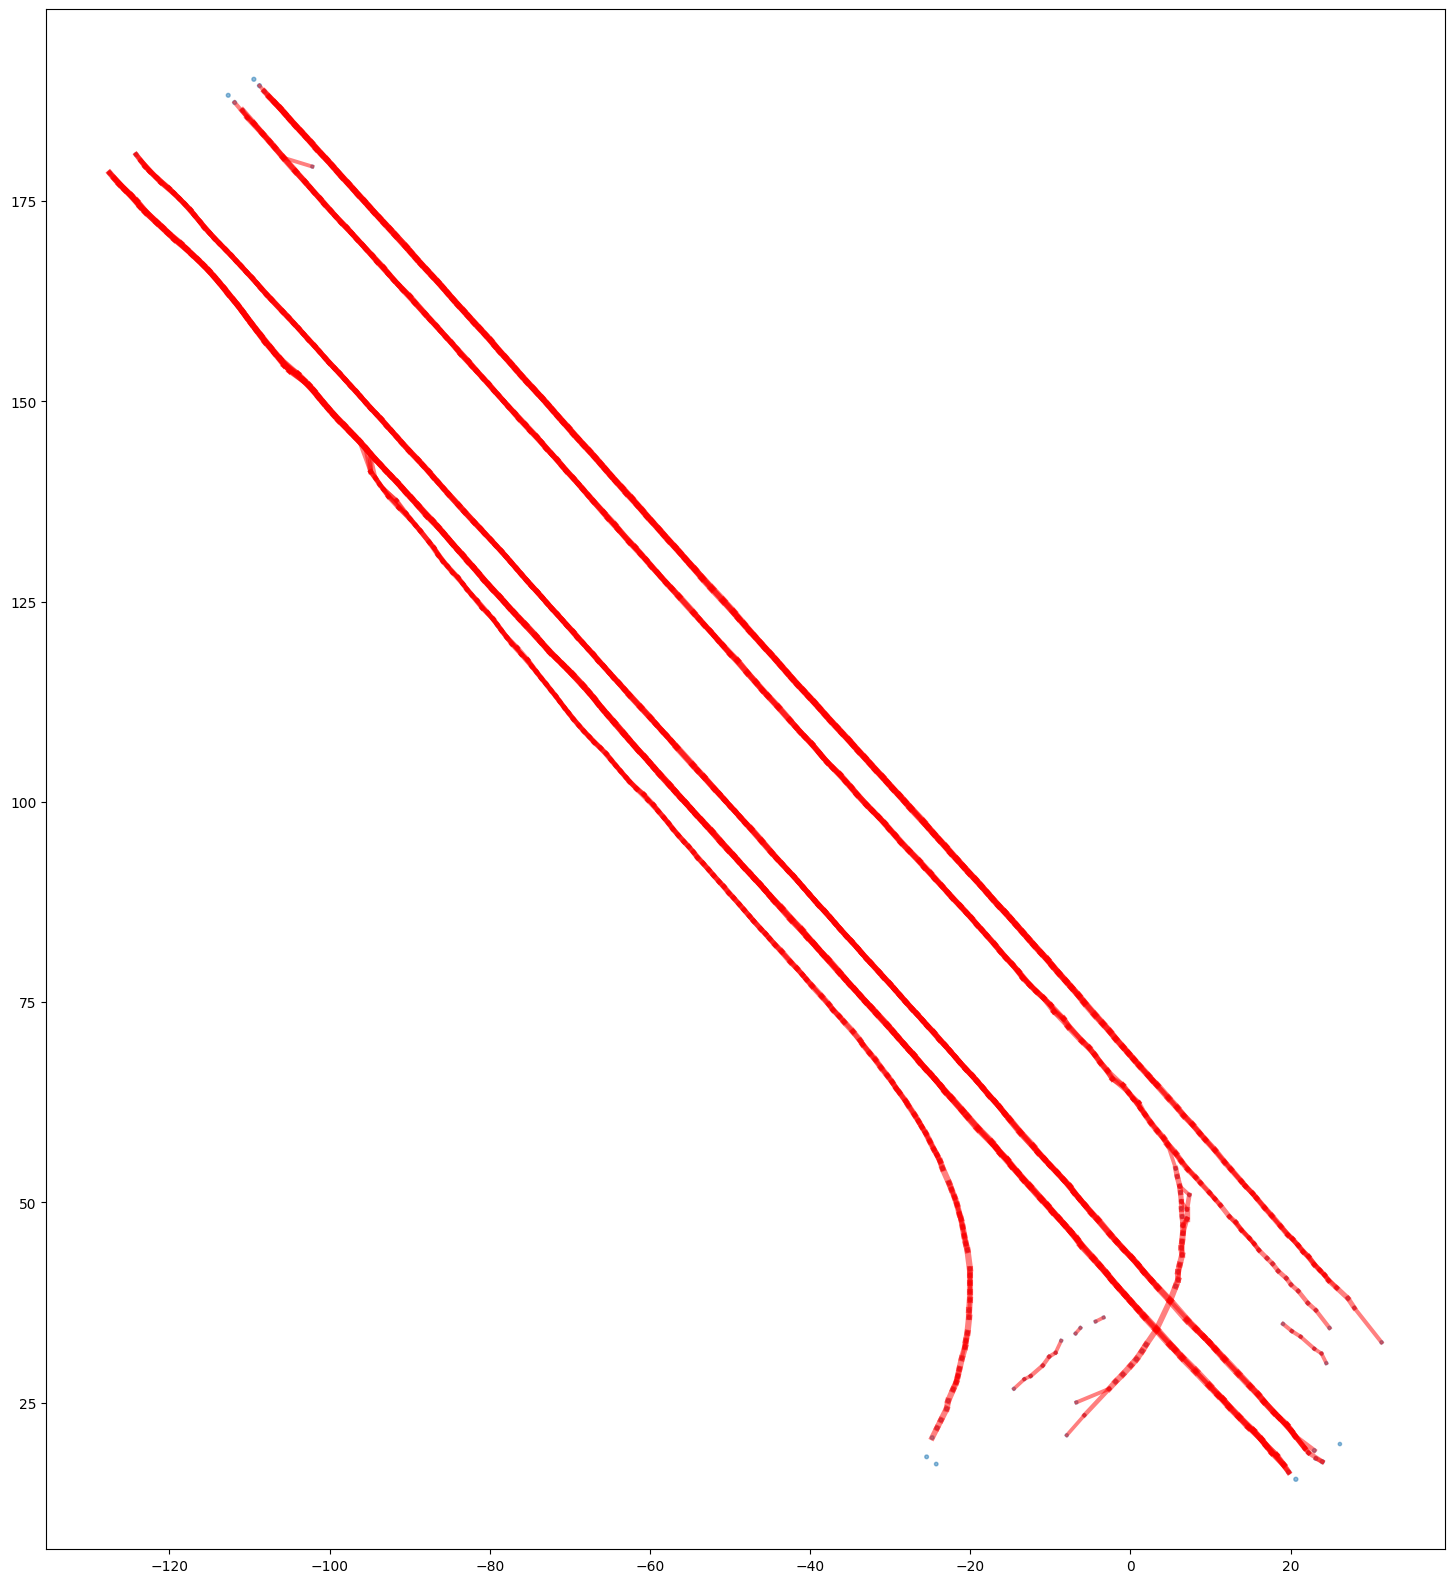

In [ ]:
ld = ld.make_graph()

fig, ax = ld.plot_graph()

# update the size of the figure
fig.set_size_inches(20, 20)

### Cleanup the Graph

function: clean_graph_ins took: 0.0005252361297607422 seconds
function: clean_graph_outs took: 0.00046706199645996094 seconds
function: plot_graph took: 0.5216588973999023 seconds


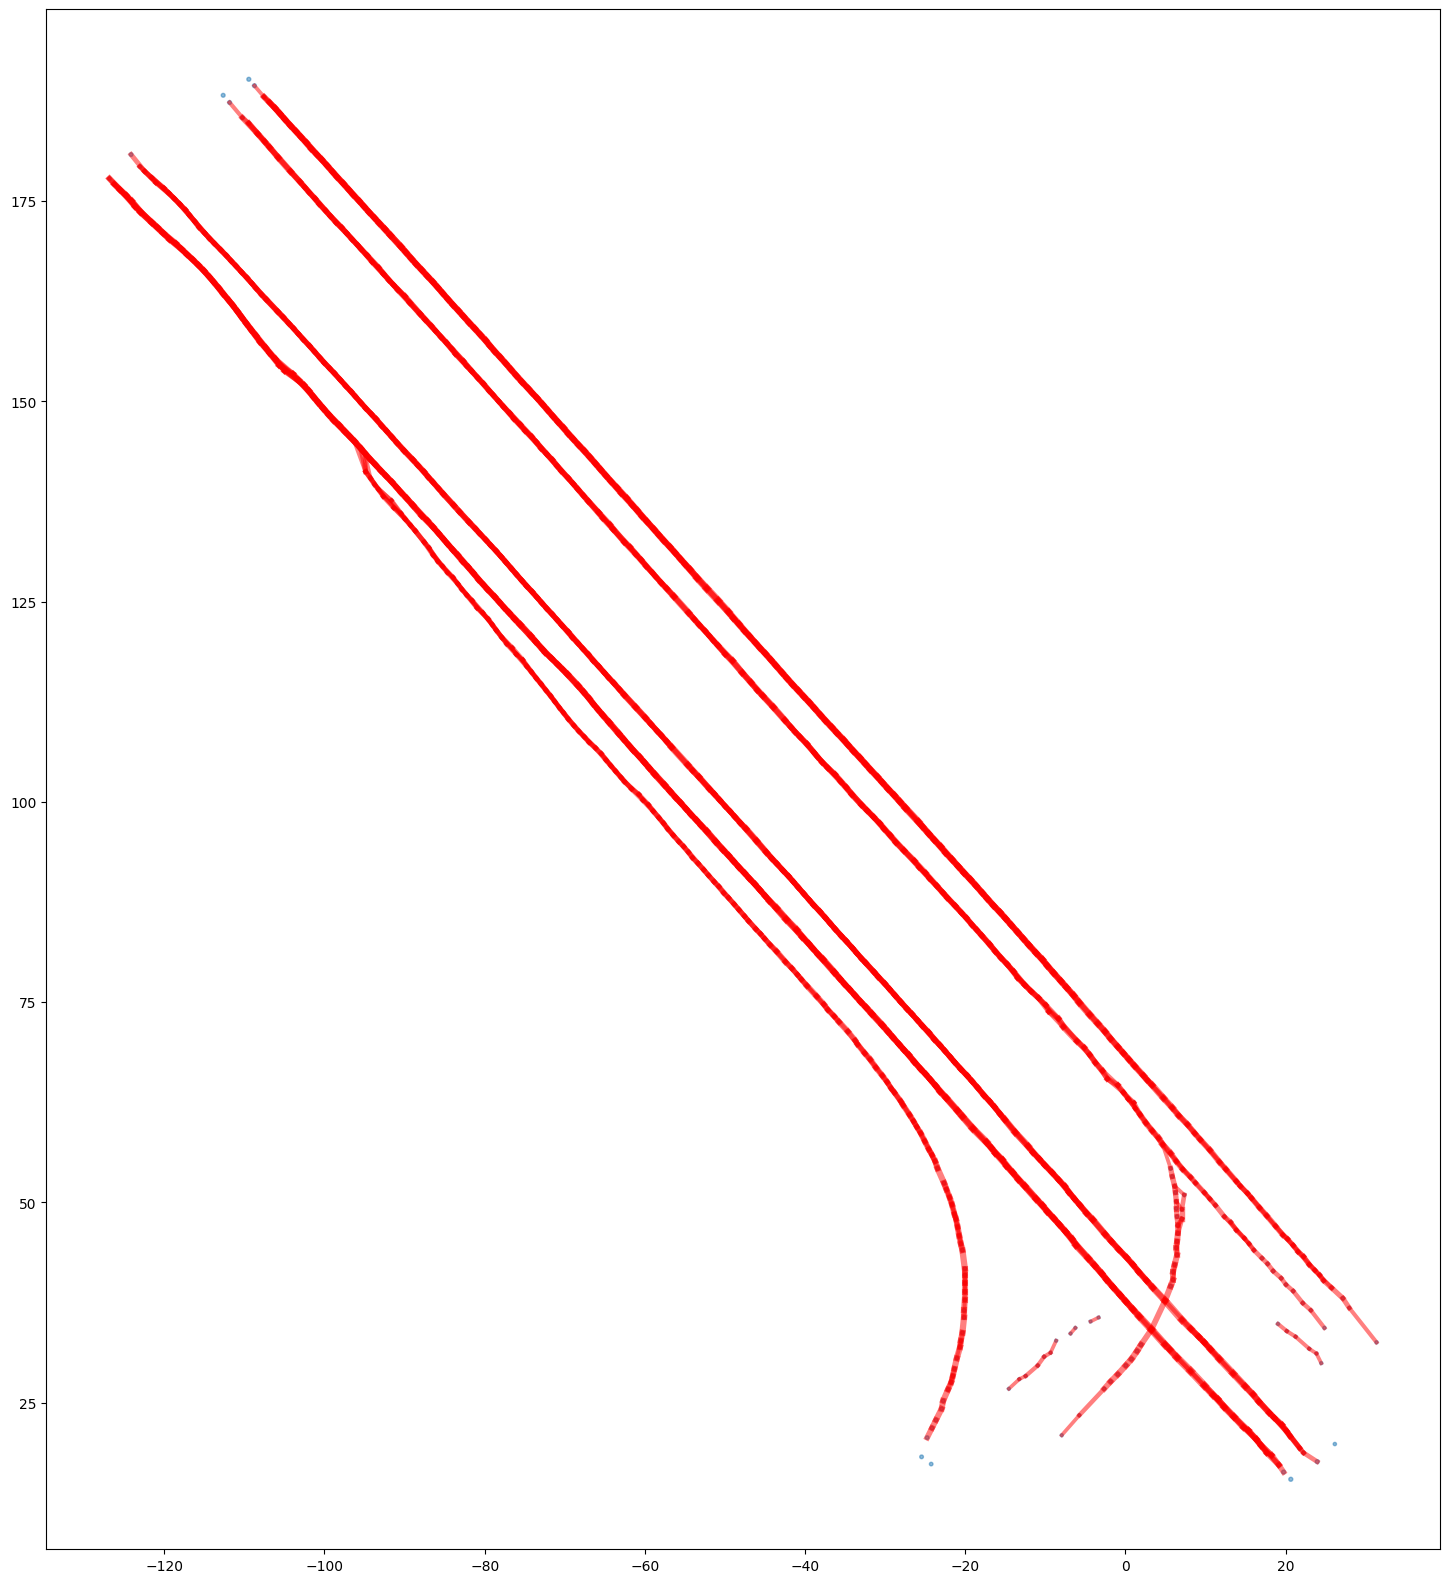

In [ ]:
ld = ld.clean_graph_ins().clean_graph_outs()

fig, ax = ld.plot_graph()

# update the size of the figure
fig.set_size_inches(20, 20)

### Cleanup the Graph

function: drop_bidirectional_edges took: 0.0010068416595458984 seconds
function: clean_graph_ins took: 0.0004999637603759766 seconds
function: clean_graph_outs took: 0.00042319297790527344 seconds
function: clean_subgraphs took: 0.012907028198242188 seconds
function: clean_isolated_nodes took: 0.0002129077911376953 seconds
function: plot_graph took: 0.5001647472381592 seconds


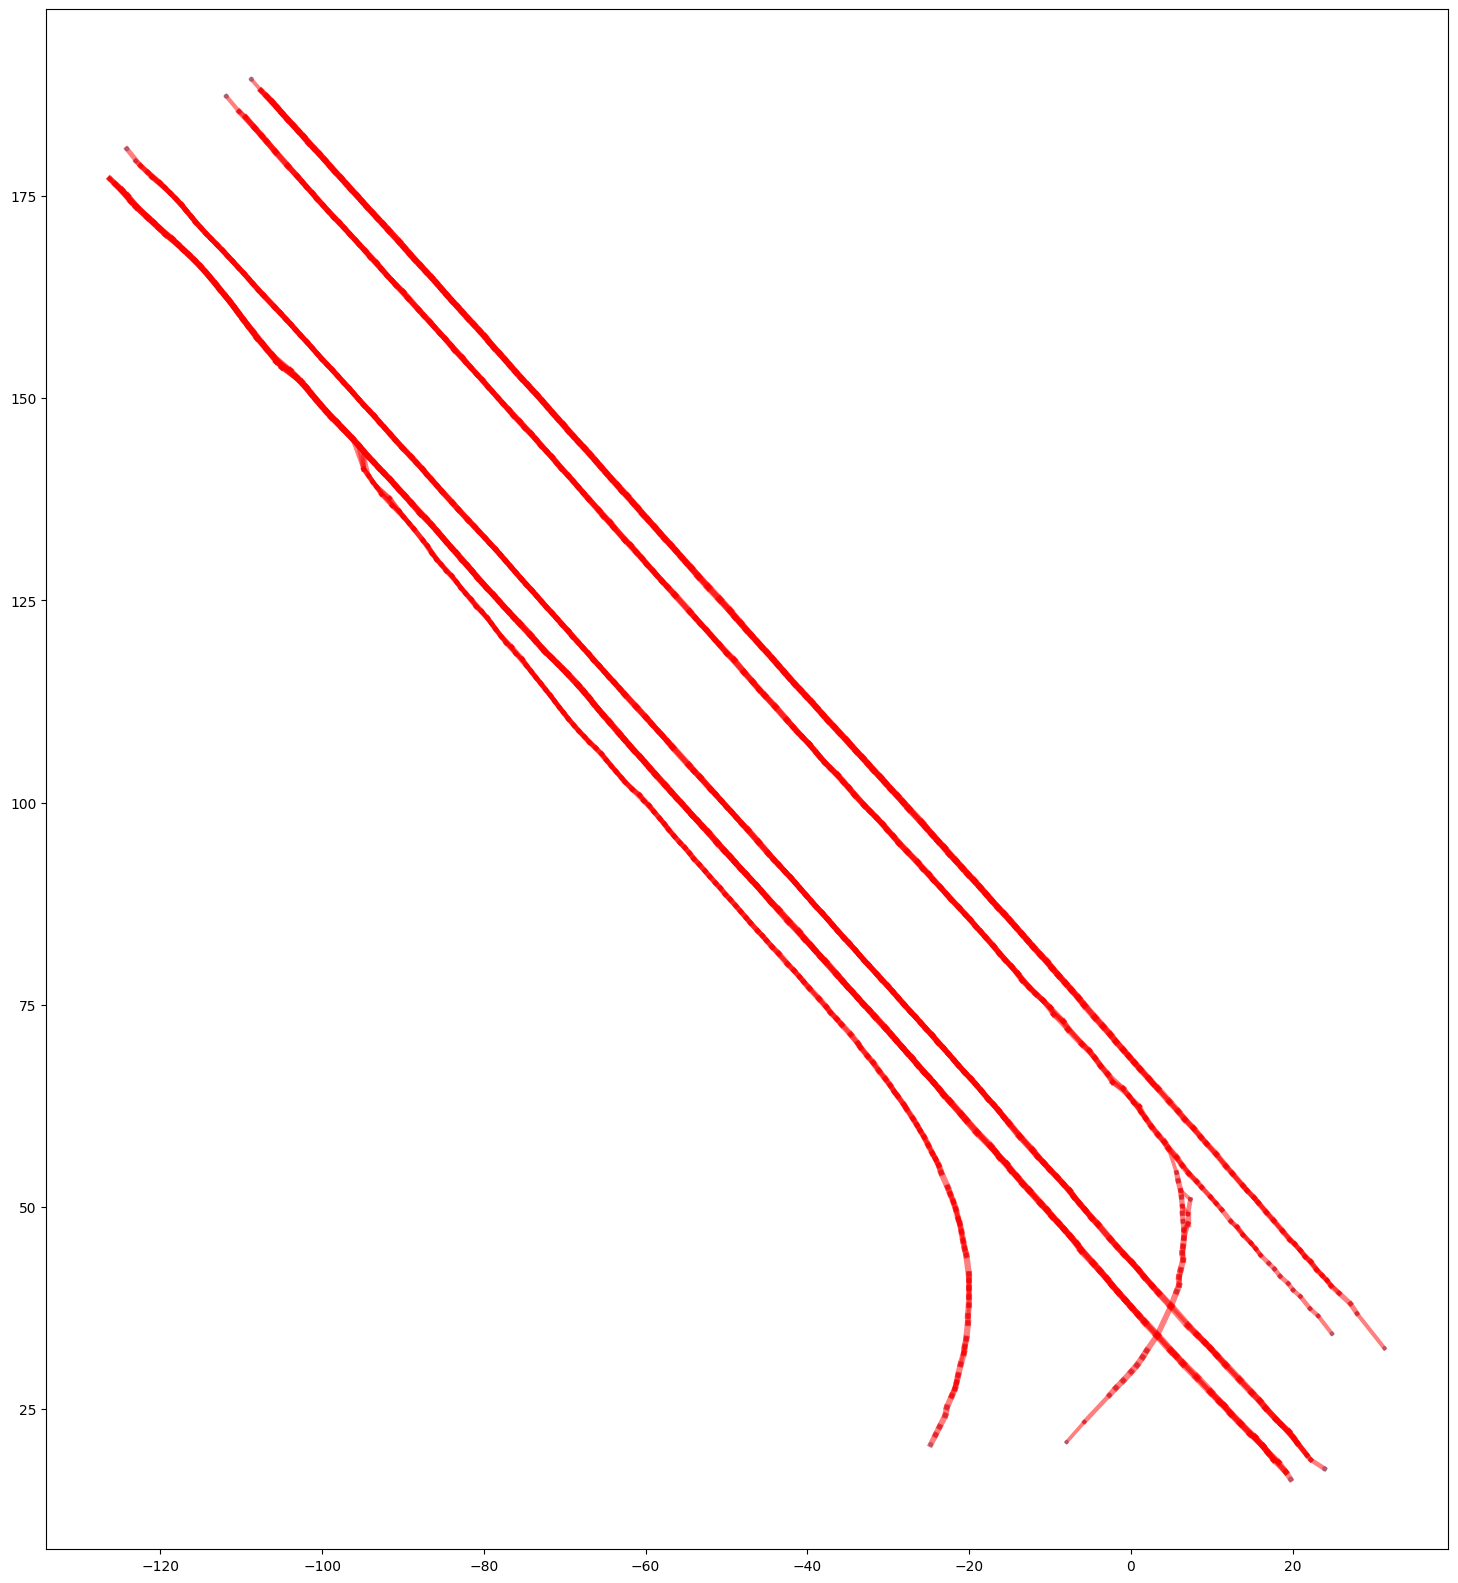

In [ ]:
ld = (
    ld
    .drop_bidirectional_edges()
    .clean_graph_ins()
    .clean_graph_outs()
    .clean_subgraphs()
    .clean_isolated_nodes()
)

fig, ax = ld.plot_graph()

# update the size of the figure
fig.set_size_inches(20, 20)

### Find the Routes/Lanes

In [ ]:
ld = ld.get_birth_nodes().get_death_nodes()
routes = ld.create_routes()

function: get_birth_nodes took: 0.0005257129669189453 seconds
function: get_death_nodes took: 0.00034308433532714844 seconds
function: create_routes took: 0.03330373764038086 seconds


#### Split Routes into Non-Overlapping Segments

In [ ]:
new_routes = ld.consolidate_routes(routes, min_route_length_m=5)

function: consolidate_routes took: 0.001936197280883789 seconds


function: plot_graph took: 0.5170869827270508 seconds
function: plot_routes took: 0.05857992172241211 seconds


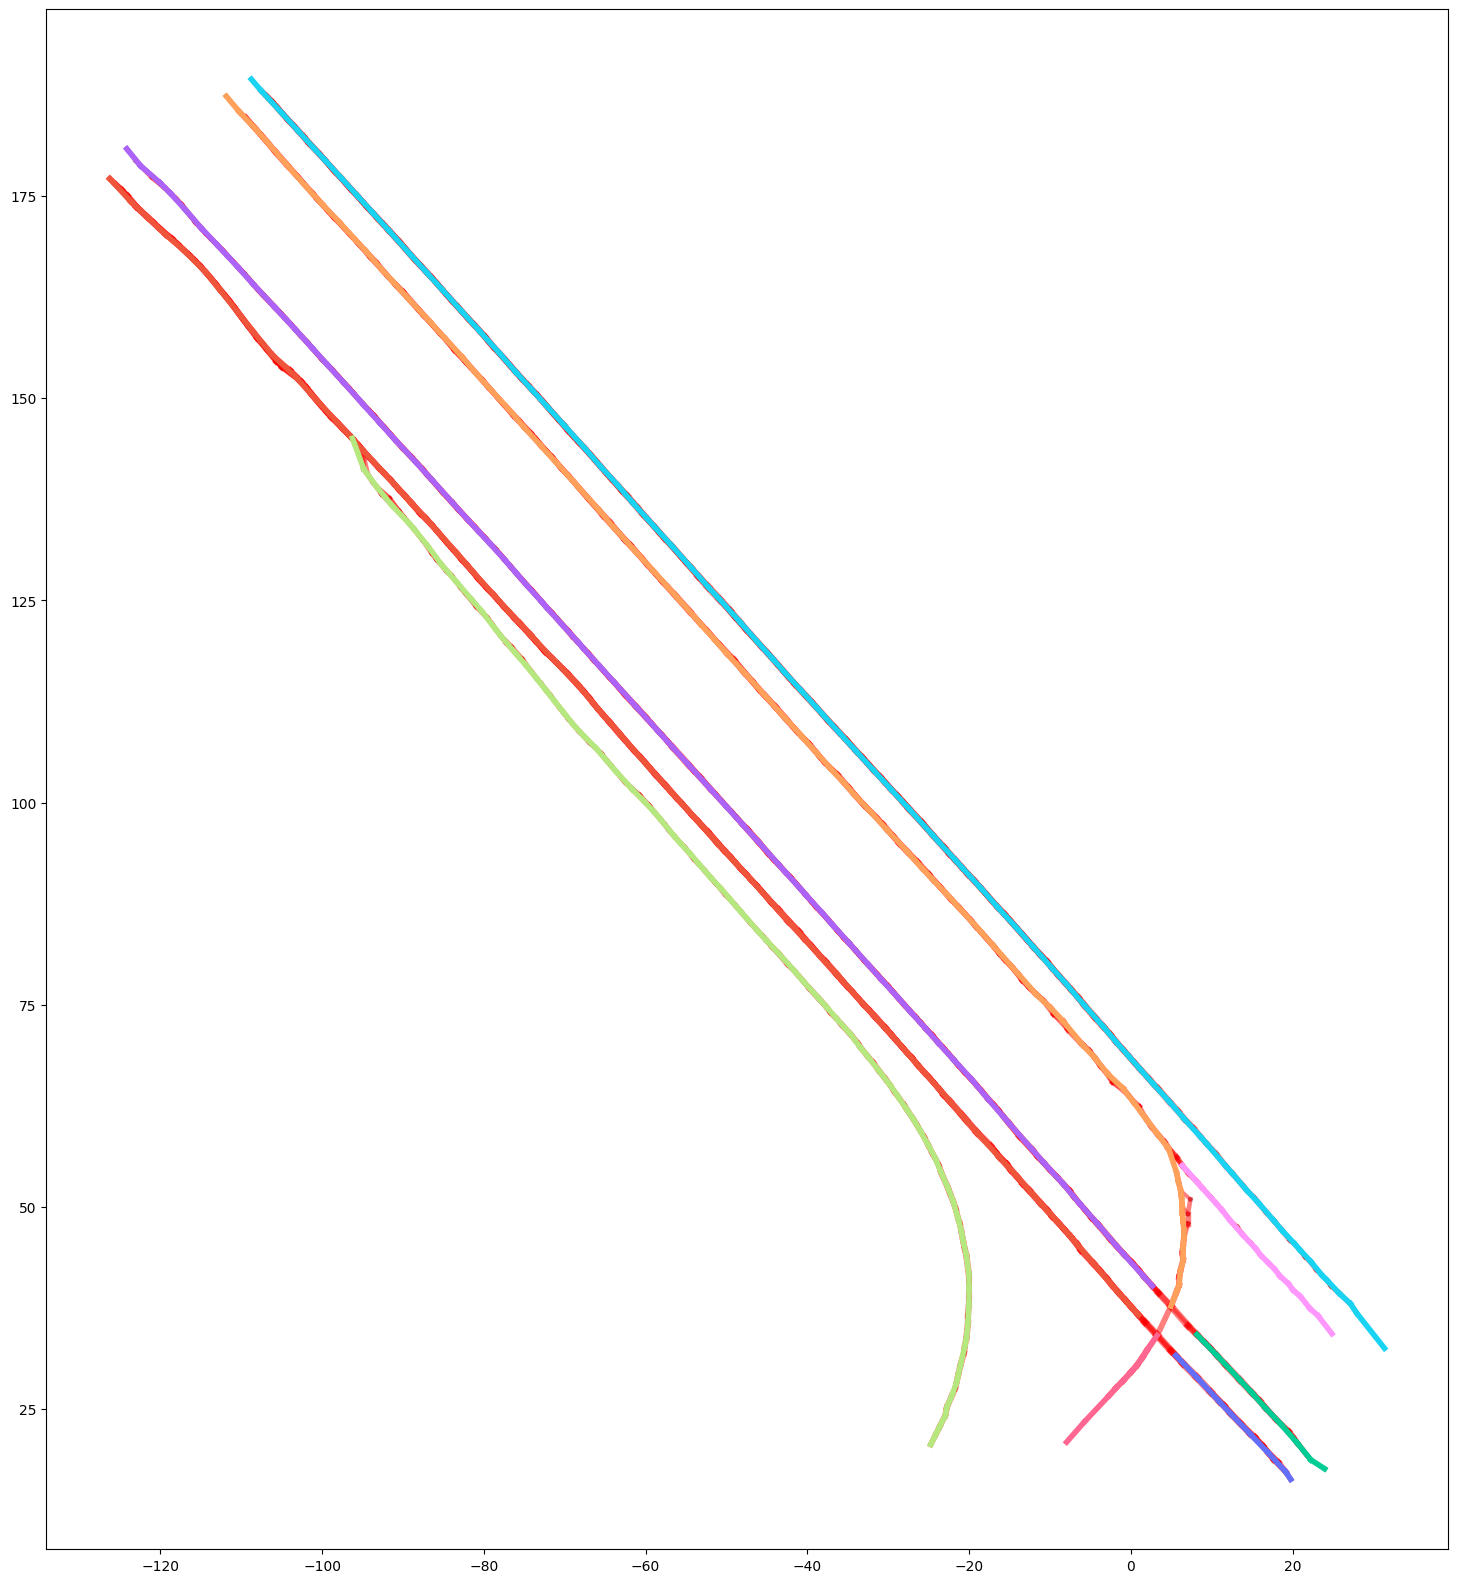

In [ ]:
import plotly.express as px

fig, ax = ld.plot_graph()
fig, ax = ld.plot_routes(new_routes, ax=ax, color_scale=(px.colors.qualitative.Plotly + px.colors.qualitative.D3 + px.colors.qualitative.Alphabet + px.colors.qualitative.Dark24))

# update the size of the figure
fig.set_size_inches(20, 20)